# Supervised Super Resolution 

In [83]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm

### Load Data

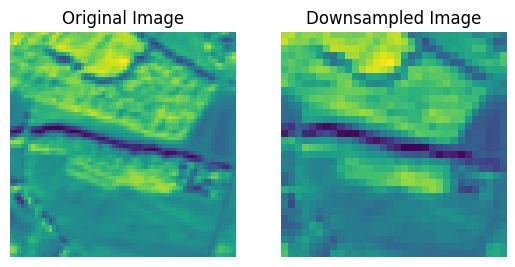

In [65]:
img_original = torch.load('data/tensor_b8.pt').cuda()
img_ds = torch.load('data/tensor_b8_ds.pt').cuda()


looked_up = 100
plt.figure()
plt.subplot(121)
plt.imshow(img_original[looked_up,:,:].cpu())
plt.axis('off')
plt.title('Original Image')
plt.subplot(122)
plt.imshow(img_ds[looked_up,:,:].cpu())
plt.axis('off')
plt.title('Downsampled Image')
plt.show()

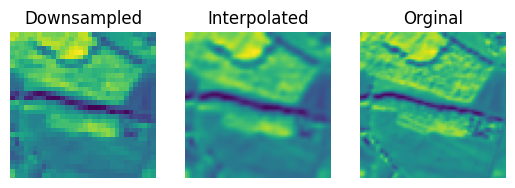

In [66]:
img_interp = nn.functional.interpolate(img_ds.unsqueeze(1),size=(64,64),mode='bicubic').squeeze(1)

looked_up = 100
plt.figure()
plt.subplot(131)
plt.imshow(img_ds[looked_up,:,:].cpu())
plt.axis('off')
plt.title('Downsampled')
plt.subplot(132)
plt.imshow(img_interp[looked_up,:,:].cpu())
plt.axis('off')
plt.title('Interpolated')
plt.subplot(133)
plt.imshow(img_original[looked_up,:,:].cpu())
plt.axis('off')
plt.title('Orginal')
plt.show()

### Prepare Datasets

In [73]:
train_valid_dataset = torch.utils.data.dataset.TensorDataset(img_ds,img_original)
train_size = int(0.8*len(train_valid_dataset))
test_size = len(train_valid_dataset)-train_size
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(
    train_valid_dataset, [train_size, test_size]
)

In [77]:
mean_ = torch.zeros_like(train_dataset[0][0])
std_ = torch.zeros_like(train_dataset[0][0])
for img, _ in train_dataset:
    mean_ += img
mean_ /= len(train_dataset)
for img, _ in train_dataset:
    std_ += (mean_ - img) ** 2
std_ /= len(train_dataset)
std_ = torch.sqrt(std_)
std_[std_ == 0] = 1

In [78]:
class DatasetTransformer(torch.utils.data.Dataset):
    def __init__(self, base_dataset, transform):
        self.base_dataset = base_dataset
        self.transform = transform

    def __getitem__(self, index):
        img, target = self.base_dataset[index]
        return self.transform(img), target

    def __len__(self):
        return len(self.base_dataset)


data_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Lambda(lambda x: (x - mean_) / std_)]
)
train_dataset = DatasetTransformer(train_dataset, data_transforms)
valid_dataset = DatasetTransformer(valid_dataset, data_transforms)

In [79]:
num_threads = 4  # Loading the dataset is using 4 CPU threads
batch_size = 512  # Using minibatches of 512 samples

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_threads
)

valid_loader = torch.utils.data.DataLoader(
    dataset=valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_threads
)

In [82]:
class CNNSuperResolutionModel(nn.Module):
    def __init__(self, in_size: int, out_size: int):
        super(CNNSuperResolutionModel, self).__init__()
        self.in_size = in_size
        self.out_size = out_size
        self.layers = nn.Sequential(
            nn.Conv2d(in_size, out_size, kernel_size=9, padding=4),
            nn.LazyBatchNorm2d(),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_size, in_size, kernel_size=5, padding=2),
            nn.LazyBatchNorm2d(),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_size, out_size, kernel_size=5, padding=2)
        )
        
        def forward(self, X:torch.Tensor) -> torch.Tensor:
            y = self.layers(X)

In [85]:
n_epochs = 50
learning_rate = 0.0001
model = CNNSuperResolutionModel(32,64)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_set_len = len(train_loader)
val_set_len = len(valid_loader)
train_loss, val_loss = [], []

for epoch in tqdm(range(n_epochs),desc='Epoch'):
    model.train()
    accu = 0.0

    for X_, y_ in train_loader:
        # Forward pass
        y_hat = model(X_)
        loss = loss_fn(y_hat, y_)
        accu += loss.item()

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss.append(accu / train_set_len)

    # Validation - no gradient & eval mode
    model.eval()
    accu = 0.0
    with torch.no_grad():
        for X_, y_ in valid_loader:
            # Forward pass
            y_hat = model(X_)
            loss = loss_fn(y_hat, y_)
            accu += loss.item()
        val_loss.append(accu / val_set_len)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Epoch:   0%|          | 0/50 [00:00<?, ?it/s]


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_610/1369449794.py", line 7, in __getitem__
    img, target = self.base_dataset[index]
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataset.py", line 290, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataset.py", line 188, in __getitem__
    return tuple(tensor[index] for tensor in self.tensors)
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataset.py", line 188, in <genexpr>
    return tuple(tensor[index] for tensor in self.tensors)
RuntimeError: CUDA error: initialization error
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
